# ***Project Time Series Using NO2 from Copernicus***

## **Dataset dari Copernicus**

In [ ]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
# ==============================================================================
# 1. KONEKSI & 2. DEFINISI AREA (AOI)
# (Tidak ada perubahan di sini)
# ==============================================================================
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()


In [ ]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [113.76938301228396, -7.0503186921347223],
            [113.76938301228396, -7.050631550698786],
            [113.80355738445064, -7.050631550698786],
            [113.80355738445064, -7.0503186921347223],
            [113.76938301228396, -7.0503186921347223]
        ]
    ]
}

In [ ]:
s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-10-19", "2025-10-19"],
    spatial_extent={
        "west": 113.749308389220396,
        "south": -7.05063150609786,
        "east": 113.80355730445064,
        "north": -7.003180921347223,
    },
    bands=["NO2"],
)

In [ ]:
# 4. Hitung rata-rata harian
s5p_no2_daily = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

# 5. Hitung rata-rata spasial berdasarkan AOI
s5p_no2_aoi = s5p_no2_daily.aggregate_spatial(
    geometries=aoi,
    reducer="mean"
)

job = s5p_no2.execute_batch(title="NO2 in Lenteng", outputfile="NO2_in_Lenteng(1).nc")

In [64]:
file_path = 'NO2_in_Lenteng.csv'

In [65]:
# Mengimpor data dari CSV
df = pd.read_csv(file_path)

# Melakukan konversi tanggal (tetap penting)
df['date'] = pd.to_datetime(df['t'], errors='coerce')
df = df.set_index('t')

print(df)

                    x         y  crs           NO2       date
t                                                            
2024-10-19  113.77659 -7.020542  b''  1.340432e-05 2024-10-19
2024-10-19  113.77659 -7.055264  b''  1.340432e-05 2024-10-19
2024-10-20  113.77659 -7.020542  b''  1.174169e-05 2024-10-20
2024-10-20  113.77659 -7.055264  b''  1.174169e-05 2024-10-20
2024-10-21  113.77659 -7.020542  b''           NaN 2024-10-21
...               ...       ...  ...           ...        ...
2025-10-16  113.77659 -7.055264  b''  1.563201e-05 2025-10-16
2025-10-17  113.77659 -7.020542  b''  9.747071e-07 2025-10-17
2025-10-17  113.77659 -7.055264  b''  1.937528e-05 2025-10-17
2025-10-18  113.77659 -7.020542  b''  1.624941e-05 2025-10-18
2025-10-18  113.77659 -7.055264  b''  1.261915e-05 2025-10-18

[728 rows x 5 columns]


## **Data Processing**

In [66]:
dataNO2 = df.copy()

In [67]:
df.dropna(subset=['date'], inplace=True)

In [68]:
# Menjadikan kolom 'date' sebagai index DataFrame
df.set_index('date', inplace=True)

# Memilih hanya kolom NO2 yang akan kita proses
df_no2 = df[['NO2']].copy()

### *Proses Interpolasi*

In [69]:
# ==============================================================================
# 2. PROSES INTERPOLASI
# ==============================================================================
df_no2['NO2_interpolated'] = df_no2['NO2'].interpolate(method='time')

print("Proses interpolasi selesai. Berikut adalah perbandingan data:")

Proses interpolasi selesai. Berikut adalah perbandingan data:


In [70]:
print(df_no2.head(10)) # Menampilkan 10 baris pertama

                 NO2  NO2_interpolated
date                                  
2024-10-19  0.000013          0.000013
2024-10-19  0.000013          0.000013
2024-10-20  0.000012          0.000012
2024-10-20  0.000012          0.000012
2024-10-21       NaN          0.000009
2024-10-21       NaN          0.000009
2024-10-22       NaN          0.000006
2024-10-22  0.000006          0.000006
2024-10-23  0.000021          0.000021
2024-10-23       NaN          0.000021


C:\Users\MyBook Z Series\AppData\Local\Temp\ipykernel_15868\3383062614.py:20: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


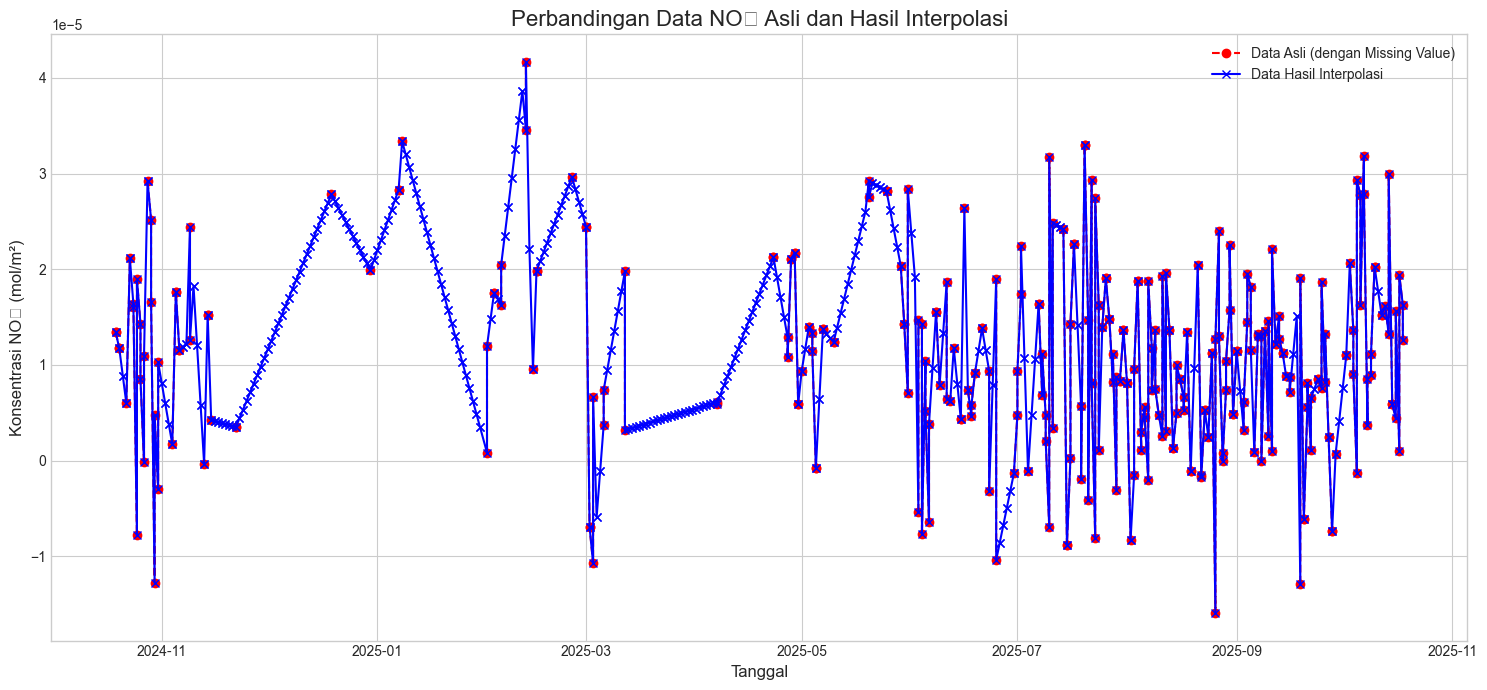

In [71]:
# ==============================================================================
# 3. VISUALISASI HASIL
# ==============================================================================
plt.style.use('seaborn-v0_8-whitegrid') # Mengatur style grafik agar lebih bagus
plt.figure(figsize=(15, 7)) # Mengatur ukuran gambar

# Plot data asli (akan terlihat putus-putus di bagian yang kosong)
plt.plot(df_no2.index, df_no2['NO2'], 
         marker='o', linestyle='--', color='red', label='Data Asli (dengan Missing Value)')

# Plot data yang sudah diinterpolasi (garisnya akan menyambung)
plt.plot(df_no2.index, df_no2['NO2_interpolated'], 
         marker='x', linestyle='-', color='blue', label='Data Hasil Interpolasi')

# Memberi judul dan label
plt.title('Perbandingan Data NOâ‚‚ Asli dan Hasil Interpolasi', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Konsentrasi NOâ‚‚ (mol/mÂ²)', fontsize=12)
plt.legend()
plt.tight_layout()

# Menampilkan grafik
plt.show()

In [72]:
print(df_no2)

                     NO2  NO2_interpolated
date                                      
2024-10-19  1.340432e-05      1.340432e-05
2024-10-19  1.340432e-05      1.340432e-05
2024-10-20  1.174169e-05      1.174169e-05
2024-10-20  1.174169e-05      1.174169e-05
2024-10-21           NaN      8.866901e-06
...                  ...               ...
2025-10-16  1.563201e-05      1.563201e-05
2025-10-17  9.747071e-07      9.747071e-07
2025-10-17  1.937528e-05      1.937528e-05
2025-10-18  1.624941e-05      1.624941e-05
2025-10-18  1.261915e-05      1.261915e-05

[728 rows x 2 columns]


In [73]:
# Mengambil data kolom NO2 saja
data = df_no2[['NO2_interpolated']].copy()

In [74]:
print(data)

            NO2_interpolated
date                        
2024-10-19      1.340432e-05
2024-10-19      1.340432e-05
2024-10-20      1.174169e-05
2024-10-20      1.174169e-05
2024-10-21      8.866901e-06
...                      ...
2025-10-16      1.563201e-05
2025-10-17      9.747071e-07
2025-10-17      1.937528e-05
2025-10-18      1.624941e-05
2025-10-18      1.261915e-05

[728 rows x 1 columns]


### *Dataset SUPERVISED*

In [75]:
# ==============================================================================
# MEMBUAT DATASET SUPERVISED (LAG FEATURES)
# ==============================================================================
# Fungsi ini akan mengubah data time series menjadi format X dan y
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Mengubah time series menjadi dataset supervised.
    n_in: Jumlah observasi lampau (X).
    n_out: Jumlah observasi masa depan (y).
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Gabungkan semua
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Hapus baris dengan nilai NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# --- Menggunakan fungsi ---
# Kita akan menggunakan data 3 hari sebelumnya (t-3, t-2, t-1) untuk memprediksi hari ini (t)
n_lags = 4
supervised_data = series_to_supervised(data, n_lags, 1)

# Mengganti nama kolom agar lebih mudah dibaca
supervised_data.rename(columns={
    'var1(t-4)': 'NO2(t-4)',
    'var1(t-3)': 'NO2(t-3)',
    'var1(t-2)': 'NO2(t-2)',
    'var1(t-1)': 'NO2(t-1)',
    'var1(t)': 'Target_NO2(t)'
}, inplace=True)

print("--- Dataset Setelah Diubah ke Format Supervised ---")
print(supervised_data.head())

--- Dataset Setelah Diubah ke Format Supervised ---
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)  Target_NO2(t)
date                                                             
2024-10-21  0.000013  0.000013  0.000012  0.000012       0.000009
2024-10-21  0.000013  0.000012  0.000012  0.000009       0.000009
2024-10-22  0.000012  0.000012  0.000009  0.000009       0.000006
2024-10-22  0.000012  0.000009  0.000009  0.000006       0.000006
2024-10-23  0.000009  0.000009  0.000006  0.000006       0.000021


### *Memisahkan Antara Data Testing dan Traning*

In [76]:
# ==============================================================================
# 3. PEMISAHAN DATA: TRAINING & TESTING
# ==============================================================================
# Penting: Untuk time series, kita tidak boleh mengacak data. Kita membaginya berdasarkan urutan waktu.
values = supervised_data.values
train_size = int(len(values) * 0.8)  # 80% untuk training
train, test = values[0:train_size], values[train_size:len(values)]

# Pisahkan antara fitur (X) dan target (y)
# X adalah semua kolom kecuali kolom terakhir
# y adalah kolom terakhir (target)
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

print(f"\nJumlah data training: {len(X_train)} baris")
print(f"Jumlah data testing: {len(X_test)} baris")


Jumlah data training: 579 baris
Jumlah data testing: 145 baris


### *Normaliasi Dataset MIN-MAX SCALER*

In [77]:
# ==============================================================================
# 4. NORMALISASI DATA DENGAN MIN-MAX SCALER
# ==============================================================================
# Normalisasi mengubah rentang nilai data menjadi antara 0 dan 1.

# --- Normalisasi Fitur (X) ---
# PENTING: Scaler di-"fit" HANYA pada data training untuk mencegah kebocoran data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_X = scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# --- Normalisasi Target (y) ---
# Kita juga perlu menormalisasi target, dan harus menggunakan scaler terpisah
scaler_y = MinMaxScaler(feature_range=(0, 1))
# y perlu diubah bentuknya menjadi 2D untuk scaler
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

scaler_y = scaler_y.fit(y_train_reshaped)
y_train_scaled = scaler_y.transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

print("\n--- Contoh Data Setelah Normalisasi ---")
print("X_train_scaled (5 baris pertama):")
print(X_train_scaled[:5])

print("\ny_train_scaled (5 baris pertama):")
print(y_train_scaled[:5])

print("\nâœ… Proses selesai. Data sekarang siap untuk dilatih menggunakan model machine learning.")


--- Contoh Data Setelah Normalisasi ---
X_train_scaled (5 baris pertama):
[[0.4808927  0.4808927  0.45034895 0.45034895]
 [0.4808927  0.45034895 0.45034895 0.39753689]
 [0.45034895 0.45034895 0.39753689 0.39753689]
 [0.45034895 0.39753689 0.39753689 0.34472482]
 [0.39753689 0.39753689 0.34472482 0.34472482]]

y_train_scaled (5 baris pertama):
[[0.39753689]
 [0.39753689]
 [0.34472482]
 [0.34472482]
 [0.62289271]]

âœ… Proses selesai. Data sekarang siap untuk dilatih menggunakan model machine learning.


## **Modeling**

### *Membangun Model*

In [95]:
# ==============================================================================
# MEMBANGUN & MELATIH MODEL KNN ðŸ§ 
# ==============================================================================

k_value = 14
knn_model = KNeighborsRegressor(n_neighbors=k_value)

knn_model.fit(X_train_scaled, y_train_scaled.ravel())
print(f"âœ… Model KNN dengan k={k_value} berhasil dilatih.")

âœ… Model KNN dengan k=14 berhasil dilatih.


In [96]:
# ==============================================================================
# MEMBUAT PREDIKSI PADA DATA UJI ðŸŽ¯
# ==============================================================================
# Model akan memprediksi data uji (X_test_scaled)
y_pred_scaled = knn_model.predict(X_test_scaled)

In [97]:
# Mengembalikan prediksi ke skala asli
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Mengembalikan data uji (y_test) yang sebenarnya ke skala asli untuk perbandingan
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

In [98]:
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

print("\n--- Hasil Evaluasi Model ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")
print(f"R-squared (RÂ²): {r2:.4f}")


--- Hasil Evaluasi Model ---
Root Mean Squared Error (RMSE): 0.0000079656
R-squared (RÂ²): 0.0155


d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


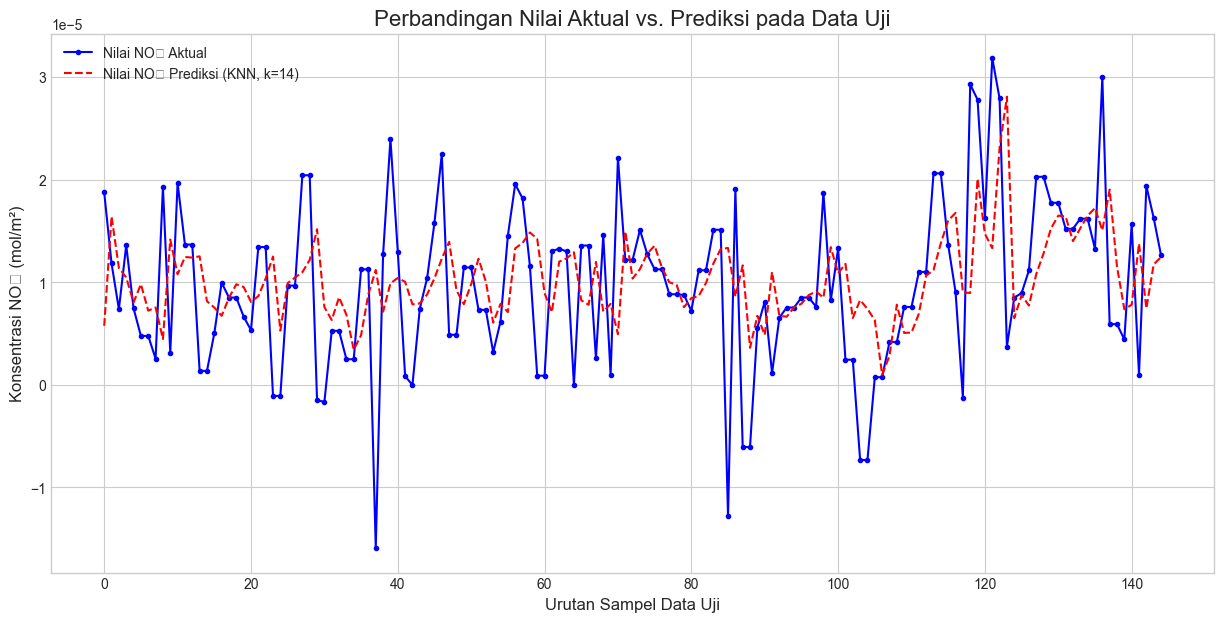

In [99]:
# ==============================================================================
# VISUALISASI HASIL PREDIKSI
# ==============================================================================
plt.figure(figsize=(15, 7))
plt.plot(y_test_actual, label='Nilai NOâ‚‚ Aktual', color='blue', marker='.', linestyle='-')
plt.plot(y_pred, label=f'Nilai NOâ‚‚ Prediksi (KNN, k={k_value})', color='red', linestyle='--')

plt.title('Perbandingan Nilai Aktual vs. Prediksi pada Data Uji', fontsize=16)
plt.xlabel('Urutan Sampel Data Uji', fontsize=12)
plt.ylabel('Konsentrasi NOâ‚‚ (mol/mÂ²)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## **Mencari nilai K Optimal**

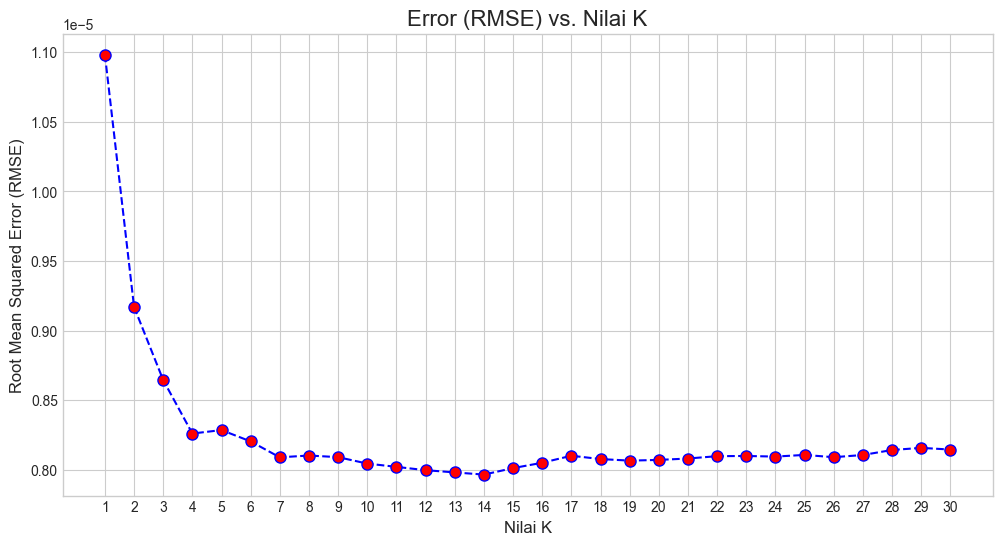


ðŸ’¡ Nilai 'k' terbaik ditemukan pada k = 14 dengan RMSE terendah.


In [100]:
error_rates = []
k_range = range(1, 31) # Mencoba nilai k dari 1 sampai 30

for k in k_range:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_scaled, y_train_scaled.ravel())
    pred_k_scaled = model.predict(X_test_scaled)

    # Kembalikan ke skala asli untuk menghitung error
    pred_k = scaler_y.inverse_transform(pred_k_scaled.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test_actual, pred_k))
    error_rates.append(rmse)

# Plotting hasilnya
plt.figure(figsize=(12, 6))
plt.plot(k_range, error_rates, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Error (RMSE) vs. Nilai K', fontsize=16)
plt.xlabel('Nilai K', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Cari nilai k dengan RMSE terendah
best_k = k_range[np.argmin(error_rates)]
print(f"\nðŸ’¡ Nilai 'k' terbaik ditemukan pada k = {best_k} dengan RMSE terendah.")